# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='RTwCmnt'
PRFX='RTwCmnt0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL retwt_cmmnt
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 5.17 s, sys: 530 ms, total: 5.7 s
Wall time: 5.85 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(5750000, 24)


retwt          0.113120
reply          0.027393
like           0.439475
retwt_cmmnt    0.007757
dtype: float64

CPU times: user 1min 1s, sys: 5.29 s, total: 1min 6s
Wall time: 1min 8s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.089206
5750000 44603 500000 44603


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
108,101\t106005\t25054\t173\t26578\t11259\t34768\t...,NaN,5621D6D1BF0187714D7939A548490B2E,NaN,07F4839C08DE4D72B0B62E4AA3B44AFA,CFAEB8CECABB888C2B2F8E24D4FFB291,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1581265760,0344E02433F065C26201B3BB1AAA40E8,1305792,102,True,1250373764,06EA0B8FB004AFD3383F53FEB3539ECA,256,724,False,1249307691,False,True,False,False,True
112,101\t41113\t146\t41541\t58768\t85110\t10454\t1...,NaN,AF2EDD10CD8D4EFF8A3DF5285D78CB99,NaN,NaN,NaN,Quote,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581069466,7B7C09388456C0B9B6B6A61A11C60FB9,313,852,False,1262677136,06EA0BEC97C5976D51DAC008A423FF64,545,413,False,1233815347,True,True,False,False,True
408,101\t44783\t10133\t10154\t10176\t60914\t11643\...,NaN,1C59F814F14A8F712E78404514CC829C,NaN,NaN,NaN,TopLevel,FA3F382BC409C271E3D6EAF8BE4648DD,1581097149,BA9258113A997F6DBA8C03D2E5B7A2EC,2380,932,False,1488470116,06EB34C6D35E065DC0B30F5B5183701B,1214,437,False,1473612676,True,True,True,False,True
414,101\t56898\t137\t27689\t30783\t10305\t61211\t1...,NaN,3609D6CF717C7EF925B143F3E22B452F,Video,NaN,NaN,Retweet,2996EB2FE8162C076D070A4C8D6532CD,1580953712,9B7E1E488B04E56D67105BAA9605174F,944,975,False,1513003339,06EB3ADFEB5B0182B664104683C5A5EB,344,211,False,1500711522,True,True,False,False,True
591,101\t12845\t37583\t10310\t10173\t82669\t10107\...,12C21C6E6EF1564DEE890157431DDAD8\t1B9D1276F79E...,0467DCED50A710815F1300276439B763,Photo,56DAFFF9D8E08D4E295F4C6F8B7D6827,AB0CD6B8058B8FE3EC0F5168D1E00693,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581301119,5307B1672E1C07BB78FCC485A745CC71,52,255,False,1438619653,06EBF31CE5E0F663E4B431249F9FBF0F,161,747,False,1260382465,True,True,False,True,True


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 20:15:47 start
2020-04-11 20:16:03 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:16:26 freq of tags
2020-04-11 20:16:34 done
CPU times: user 42.1 s, sys: 3.96 s, total: 46 s
Wall time: 48.1 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 20:16:35 start
2020-04-11 20:16:47 freq of columns using CountEncoder
2020-04-11 20:17:03 freq of tags
2020-04-11 20:17:11 done
CPU times: user 33.6 s, sys: 1.22 s, total: 34.8 s
Wall time: 36.3 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 38.4 s, sys: 2.33 s, total: 40.7 s
Wall time: 41.6 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
#  'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
#  'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
#  'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
#  'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
29


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265768	vl's binary_logloss: 0.282753
[200]	tr's binary_logloss: 0.259553	vl's binary_logloss: 0.282509
[300]	tr's binary_logloss: 0.254317	vl's binary_logloss: 0.282472
Early stopping, best iteration is:
[232]	tr's binary_logloss: 0.257857	vl's binary_logloss: 0.282379


tune_feature_fraction, val_score: 0.282379:  14%|#4        | 1/7 [00:22<02:12, 22.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265057	vl's binary_logloss: 0.282928
[200]	tr's binary_logloss: 0.258526	vl's binary_logloss: 0.282594
[300]	tr's binary_logloss: 0.253044	vl's binary_logloss: 0.28263
Early stopping, best iteration is:
[269]	tr's binary_logloss: 0.254533	vl's binary_logloss: 0.282533


tune_feature_fraction, val_score: 0.282379:  29%|##8       | 2/7 [00:41<01:45, 21.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264837	vl's binary_logloss: 0.282842
[200]	tr's binary_logloss: 0.257978	vl's binary_logloss: 0.28289
Early stopping, best iteration is:
[113]	tr's binary_logloss: 0.263772	vl's binary_logloss: 0.282733


tune_feature_fraction, val_score: 0.282379:  43%|####2     | 3/7 [00:52<01:13, 18.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263617	vl's binary_logloss: 0.283186
[200]	tr's binary_logloss: 0.256038	vl's binary_logloss: 0.283419
Early stopping, best iteration is:
[125]	tr's binary_logloss: 0.26142	vl's binary_logloss: 0.283084


tune_feature_fraction, val_score: 0.282379:  57%|#####7    | 4/7 [01:07<00:51, 17.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262027	vl's binary_logloss: 0.283692
[200]	tr's binary_logloss: 0.254581	vl's binary_logloss: 0.28368
Early stopping, best iteration is:
[125]	tr's binary_logloss: 0.259922	vl's binary_logloss: 0.283574


tune_feature_fraction, val_score: 0.282379:  71%|#######1  | 5/7 [01:19<00:31, 15.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26142	vl's binary_logloss: 0.284029
[200]	tr's binary_logloss: 0.253702	vl's binary_logloss: 0.28429
Early stopping, best iteration is:
[100]	tr's binary_logloss: 0.26142	vl's binary_logloss: 0.284029


tune_feature_fraction, val_score: 0.282379:  86%|########5 | 6/7 [01:32<00:14, 14.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260761	vl's binary_logloss: 0.284443
Early stopping, best iteration is:
[76]	tr's binary_logloss: 0.263552	vl's binary_logloss: 0.284309


tune_num_leaves, val_score: 0.282379:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.233611	vl's binary_logloss: 0.283248
Early stopping, best iteration is:
[61]	tr's binary_logloss: 0.246381	vl's binary_logloss: 0.282931


tune_num_leaves, val_score: 0.282379:   5%|5         | 1/20 [00:23<07:22, 23.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252705	vl's binary_logloss: 0.282425
Early stopping, best iteration is:
[86]	tr's binary_logloss: 0.254875	vl's binary_logloss: 0.282357


tune_num_leaves, val_score: 0.282357:  10%|#         | 2/20 [00:39<06:20, 21.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.226557	vl's binary_logloss: 0.283686
Early stopping, best iteration is:
[54]	tr's binary_logloss: 0.244466	vl's binary_logloss: 0.283003


tune_num_leaves, val_score: 0.282357:  15%|#5        | 3/20 [01:05<06:24, 22.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.238951	vl's binary_logloss: 0.283366
Early stopping, best iteration is:
[54]	tr's binary_logloss: 0.25253	vl's binary_logloss: 0.282765


tune_num_leaves, val_score: 0.282357:  20%|##        | 4/20 [01:20<05:26, 20.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.230142	vl's binary_logloss: 0.283286
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.242189	vl's binary_logloss: 0.282784


tune_num_leaves, val_score: 0.282357:  25%|##5       | 5/20 [01:41<05:08, 20.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.239598	vl's binary_logloss: 0.28285
Early stopping, best iteration is:
[64]	tr's binary_logloss: 0.249693	vl's binary_logloss: 0.282496


tune_num_leaves, val_score: 0.282357:  30%|###       | 6/20 [01:56<04:22, 18.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.234974	vl's binary_logloss: 0.283424
Early stopping, best iteration is:
[54]	tr's binary_logloss: 0.250234	vl's binary_logloss: 0.282789


tune_num_leaves, val_score: 0.282357:  35%|###5      | 7/20 [02:11<03:48, 17.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.226339	vl's binary_logloss: 0.283253
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.244069	vl's binary_logloss: 0.282697


tune_num_leaves, val_score: 0.282357:  40%|####      | 8/20 [02:34<03:51, 19.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.227355	vl's binary_logloss: 0.283181
Early stopping, best iteration is:
[64]	tr's binary_logloss: 0.240486	vl's binary_logloss: 0.282728


tune_num_leaves, val_score: 0.282357:  45%|####5     | 9/20 [02:51<03:25, 18.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254187	vl's binary_logloss: 0.282477
[200]	tr's binary_logloss: 0.242021	vl's binary_logloss: 0.282685
Early stopping, best iteration is:
[133]	tr's binary_logloss: 0.249699	vl's binary_logloss: 0.282329


tune_num_leaves, val_score: 0.282329:  50%|#####     | 10/20 [03:11<03:08, 18.86s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284725	vl's binary_logloss: 0.290457
[200]	tr's binary_logloss: 0.2826	vl's binary_logloss: 0.288536
[300]	tr's binary_logloss: 0.281589	vl's binary_logloss: 0.287696
[400]	tr's binary_logloss: 0.280961	vl's binary_logloss: 0.287184
[500]	tr's binary_logloss: 0.280533	vl's binary_logloss: 0.28688
[600]	tr's binary_logloss: 0.280221	vl's binary_logloss: 0.286665
[700]	tr's binary_logloss: 0.279983	vl's binary_logloss: 0.286508
[800]	tr's binary_logloss: 0.279797	vl's binary_logloss: 0.286415
[900]	tr's binary_logloss: 0.279651	vl's binary_logloss: 0.286326
[1000]	tr's binary_logloss: 0.279532	vl's binary_logloss: 0.286269
[1100]	tr's binary_logloss: 0.279435	vl's binary_logloss: 0.28623
[1200]	tr's binary_logloss: 0.279352	vl's binary_logloss: 0.286205
[1300]	tr's binary_logloss: 0.279281	vl's binary_logloss: 0.286191
[1400]	tr's binary_logloss: 0.27922	vl's binary_logloss: 0.286161
Early stopping

tune_num_leaves, val_score: 0.282329:  55%|#####5    | 11/20 [03:49<03:41, 24.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.258164	vl's binary_logloss: 0.282832
[200]	tr's binary_logloss: 0.247549	vl's binary_logloss: 0.282656
Early stopping, best iteration is:
[119]	tr's binary_logloss: 0.255848	vl's binary_logloss: 0.282628


tune_num_leaves, val_score: 0.282329:  60%|######    | 12/20 [04:03<02:52, 21.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253602	vl's binary_logloss: 0.282412
Early stopping, best iteration is:
[95]	tr's binary_logloss: 0.254376	vl's binary_logloss: 0.282339


tune_num_leaves, val_score: 0.282329:  65%|######5   | 13/20 [04:24<02:30, 21.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.258357	vl's binary_logloss: 0.282585
Early stopping, best iteration is:
[91]	tr's binary_logloss: 0.259426	vl's binary_logloss: 0.28252


tune_num_leaves, val_score: 0.282329:  70%|#######   | 14/20 [04:37<01:52, 18.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.248911	vl's binary_logloss: 0.282728
[200]	tr's binary_logloss: 0.233353	vl's binary_logloss: 0.283442
Early stopping, best iteration is:
[118]	tr's binary_logloss: 0.245801	vl's binary_logloss: 0.282644


tune_num_leaves, val_score: 0.282329:  75%|#######5  | 15/20 [04:53<01:30, 18.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269664	vl's binary_logloss: 0.283276
[200]	tr's binary_logloss: 0.264728	vl's binary_logloss: 0.282698
[300]	tr's binary_logloss: 0.261135	vl's binary_logloss: 0.282658
Early stopping, best iteration is:
[281]	tr's binary_logloss: 0.261727	vl's binary_logloss: 0.282587


tune_num_leaves, val_score: 0.282329:  80%|########  | 16/20 [05:08<01:08, 17.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26217	vl's binary_logloss: 0.282614
[200]	tr's binary_logloss: 0.254171	vl's binary_logloss: 0.282856
Early stopping, best iteration is:
[109]	tr's binary_logloss: 0.261357	vl's binary_logloss: 0.282562


tune_num_leaves, val_score: 0.282329:  85%|########5 | 17/20 [05:22<00:48, 16.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246285	vl's binary_logloss: 0.282643
Early stopping, best iteration is:
[68]	tr's binary_logloss: 0.253464	vl's binary_logloss: 0.282274


tune_num_leaves, val_score: 0.282274:  90%|######### | 18/20 [05:37<00:31, 15.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242582	vl's binary_logloss: 0.282432
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251594	vl's binary_logloss: 0.282225


tune_num_leaves, val_score: 0.282225:  95%|#########5| 19/20 [05:51<00:15, 15.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244255	vl's binary_logloss: 0.282731
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.252983	vl's binary_logloss: 0.282517


tune_num_leaves, val_score: 0.282225: 100%|##########| 20/20 [06:01<00:00, 18.07s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247193	vl's binary_logloss: 0.284346
Early stopping, best iteration is:
[53]	tr's binary_logloss: 0.259254	vl's binary_logloss: 0.283725


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  10%|#         | 1/10 [00:07<01:08,  7.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244258	vl's binary_logloss: 0.282987
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.253242	vl's binary_logloss: 0.28254


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  20%|##        | 2/10 [00:18<01:07,  8.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244299	vl's binary_logloss: 0.283026
Early stopping, best iteration is:
[68]	tr's binary_logloss: 0.252315	vl's binary_logloss: 0.282885


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  30%|###       | 3/10 [00:27<01:02,  8.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245492	vl's binary_logloss: 0.283194
Early stopping, best iteration is:
[75]	tr's binary_logloss: 0.251776	vl's binary_logloss: 0.282945


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  40%|####      | 4/10 [00:37<00:54,  9.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244313	vl's binary_logloss: 0.283204
Early stopping, best iteration is:
[54]	tr's binary_logloss: 0.256664	vl's binary_logloss: 0.282979


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  50%|#####     | 5/10 [00:47<00:46,  9.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246216	vl's binary_logloss: 0.283782
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.254873	vl's binary_logloss: 0.283303


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  60%|######    | 6/10 [00:55<00:36,  9.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.243708	vl's binary_logloss: 0.282462
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.245208	vl's binary_logloss: 0.282306


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  70%|#######   | 7/10 [01:06<00:28,  9.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.243277	vl's binary_logloss: 0.282822
Early stopping, best iteration is:
[75]	tr's binary_logloss: 0.249195	vl's binary_logloss: 0.282662


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  80%|########  | 8/10 [01:16<00:19,  9.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.243277	vl's binary_logloss: 0.282946
Early stopping, best iteration is:
[59]	tr's binary_logloss: 0.253893	vl's binary_logloss: 0.28275


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225:  90%|######### | 9/10 [01:26<00:09,  9.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246181	vl's binary_logloss: 0.283538
Early stopping, best iteration is:
[54]	tr's binary_logloss: 0.257948	vl's binary_logloss: 0.283312


tune_bagging_fraction_and_bagging_freq, val_score: 0.282225: 100%|##########| 10/10 [01:34<00:00,  9.43s/it]
tune_feature_fraction, val_score: 0.282225:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242582	vl's binary_logloss: 0.282432
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251594	vl's binary_logloss: 0.282225


tune_feature_fraction, val_score: 0.282225:  33%|###3      | 1/3 [00:08<00:15,  7.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.241481	vl's binary_logloss: 0.282786
Early stopping, best iteration is:
[85]	tr's binary_logloss: 0.244997	vl's binary_logloss: 0.282664


tune_feature_fraction, val_score: 0.282225:  67%|######6   | 2/3 [00:16<00:08,  8.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.241152	vl's binary_logloss: 0.282611
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.250518	vl's binary_logloss: 0.282393


tune_feature_fraction, val_score: 0.282225: 100%|##########| 3/3 [00:24<00:00,  8.33s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.282225:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.243511	vl's binary_logloss: 0.282409
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.252413	vl's binary_logloss: 0.282306


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:   5%|5         | 1/20 [00:08<02:35,  8.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242674	vl's binary_logloss: 0.282886
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251744	vl's binary_logloss: 0.282566


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  10%|#         | 2/20 [00:16<02:26,  8.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242582	vl's binary_logloss: 0.282432
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251594	vl's binary_logloss: 0.282225


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  15%|#5        | 3/20 [00:24<02:17,  8.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242649	vl's binary_logloss: 0.282796
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251598	vl's binary_logloss: 0.282435


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  20%|##        | 4/20 [00:32<02:09,  8.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242582	vl's binary_logloss: 0.282432
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251594	vl's binary_logloss: 0.282225


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  25%|##5       | 5/20 [00:40<02:01,  8.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24777	vl's binary_logloss: 0.282453
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.255049	vl's binary_logloss: 0.282236


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  30%|###       | 6/20 [00:49<01:57,  8.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24284	vl's binary_logloss: 0.282823
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.251299	vl's binary_logloss: 0.282505


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  35%|###5      | 7/20 [00:57<01:47,  8.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242958	vl's binary_logloss: 0.28278
Early stopping, best iteration is:
[74]	tr's binary_logloss: 0.249003	vl's binary_logloss: 0.282637


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  40%|####      | 8/20 [01:06<01:40,  8.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242582	vl's binary_logloss: 0.282432
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251594	vl's binary_logloss: 0.282225


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  45%|####5     | 9/20 [01:16<01:38,  8.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.248069	vl's binary_logloss: 0.282448
[200]	tr's binary_logloss: 0.233801	vl's binary_logloss: 0.282833
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.246311	vl's binary_logloss: 0.282306


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  50%|#####     | 10/20 [01:30<01:45, 10.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242582	vl's binary_logloss: 0.282432
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251594	vl's binary_logloss: 0.282225


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  55%|#####5    | 11/20 [01:40<01:34, 10.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242582	vl's binary_logloss: 0.282432
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251594	vl's binary_logloss: 0.282225


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  60%|######    | 12/20 [01:51<01:22, 10.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242854	vl's binary_logloss: 0.282572
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251664	vl's binary_logloss: 0.282261


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  65%|######5   | 13/20 [02:01<01:12, 10.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242853	vl's binary_logloss: 0.282572
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251663	vl's binary_logloss: 0.282261


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  70%|#######   | 14/20 [02:11<01:01, 10.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242854	vl's binary_logloss: 0.282572
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.251664	vl's binary_logloss: 0.282261


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  75%|#######5  | 15/20 [02:22<00:51, 10.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242531	vl's binary_logloss: 0.282843
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.251187	vl's binary_logloss: 0.282445


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  80%|########  | 16/20 [02:32<00:41, 10.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242532	vl's binary_logloss: 0.282843
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.251187	vl's binary_logloss: 0.282445


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  85%|########5 | 17/20 [02:42<00:30, 10.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242454	vl's binary_logloss: 0.282765
Early stopping, best iteration is:
[75]	tr's binary_logloss: 0.248543	vl's binary_logloss: 0.282598


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  90%|######### | 18/20 [02:53<00:20, 10.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242599	vl's binary_logloss: 0.282809
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.251187	vl's binary_logloss: 0.282445


tune_lambda_l1_and_lambda_l2, val_score: 0.282225:  95%|#########5| 19/20 [03:04<00:10, 10.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251181	vl's binary_logloss: 0.281989
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.252512	vl's binary_logloss: 0.281965


tune_lambda_l1_and_lambda_l2, val_score: 0.281965: 100%|##########| 20/20 [03:18<00:00,  9.93s/it]
tune_min_child_samples, val_score: 0.281965:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250968	vl's binary_logloss: 0.282241
[200]	tr's binary_logloss: 0.23747	vl's binary_logloss: 0.28265
Early stopping, best iteration is:
[120]	tr's binary_logloss: 0.247944	vl's binary_logloss: 0.282097


tune_min_child_samples, val_score: 0.281965:  20%|##        | 1/5 [00:16<01:04, 16.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250926	vl's binary_logloss: 0.282087
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.252191	vl's binary_logloss: 0.281984


tune_min_child_samples, val_score: 0.281965:  40%|####      | 2/5 [00:31<00:47, 15.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250987	vl's binary_logloss: 0.282084
[200]	tr's binary_logloss: 0.237528	vl's binary_logloss: 0.282346
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.249355	vl's binary_logloss: 0.281987


tune_min_child_samples, val_score: 0.281965:  60%|######    | 3/5 [00:53<00:35, 17.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250905	vl's binary_logloss: 0.282398
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.252265	vl's binary_logloss: 0.282252


tune_min_child_samples, val_score: 0.281965:  80%|########  | 4/5 [01:17<00:19, 19.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251295	vl's binary_logloss: 0.282364
[200]	tr's binary_logloss: 0.237349	vl's binary_logloss: 0.282842
Early stopping, best iteration is:
[119]	tr's binary_logloss: 0.248286	vl's binary_logloss: 0.28219


tune_min_child_samples, val_score: 0.281965: 100%|##########| 5/5 [01:50<00:00, 22.11s/it]


CPU times: user 57min 36s, sys: 1h 43min 3s, total: 2h 40min 40s
Wall time: 14min 58s


## best_params

In [20]:
best_params

{'lambda_l1': 9.398258658271978,
 'lambda_l2': 0.00045468762766196657,
 'num_leaves': 147,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

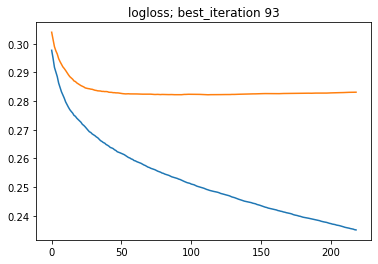

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

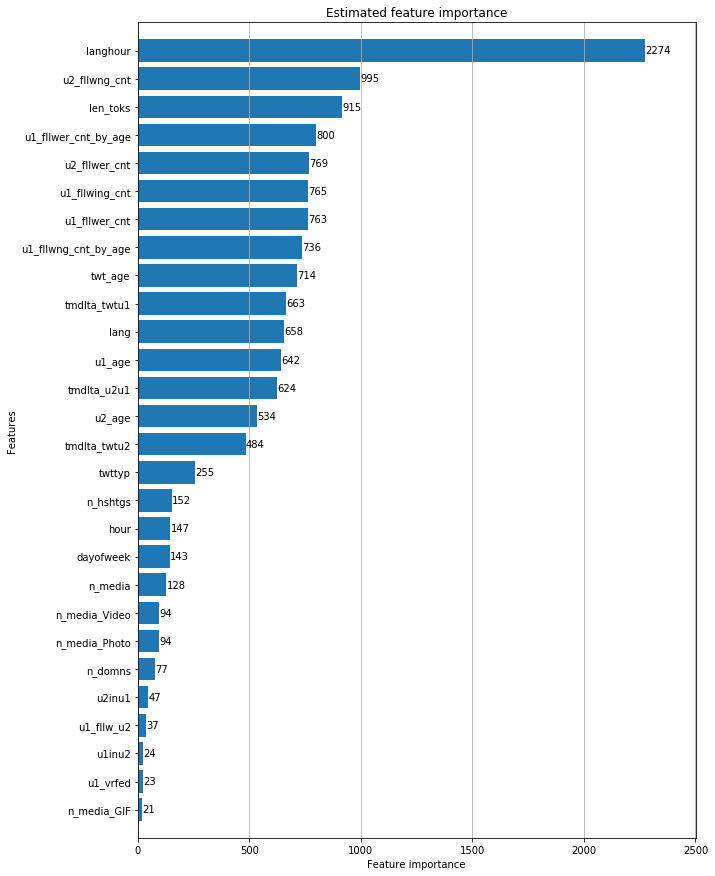

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,2274
6,u2_fllwng_cnt,995
11,len_toks,915
26,u1_fllwer_cnt_by_age,800
5,u2_fllwer_cnt,769
3,u1_fllwing_cnt,765
2,u1_fllwer_cnt,763
27,u1_fllwng_cnt_by_age,736
23,twt_age,714
21,tmdlta_twtu1,663


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 2274),
 ('u2_fllwng_cnt', 995),
 ('len_toks', 915),
 ('u1_fllwer_cnt_by_age', 800),
 ('u2_fllwer_cnt', 769),
 ('u1_fllwing_cnt', 765),
 ('u1_fllwer_cnt', 763),
 ('u1_fllwng_cnt_by_age', 736),
 ('twt_age', 714),
 ('tmdlta_twtu1', 663),
 ('lang', 658),
 ('u1_age', 642),
 ('tmdlta_u2u1', 624),
 ('u2_age', 534),
 ('tmdlta_twtu2', 484),
 ('twttyp', 255),
 ('n_hshtgs', 152),
 ('hour', 147),
 ('dayofweek', 143),
 ('n_media', 128),
 ('n_media_Photo', 94),
 ('n_media_Video', 94),
 ('n_domns', 77),
 ('u2inu1', 47),
 ('u1_fllw_u2', 37),
 ('u1inu2', 24),
 ('u1_vrfed', 23),
 ('n_media_GIF', 21),
 ('u2_vrfed', 0)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u2_fllwng_cnt',
 'len_toks',
 'u1_fllwer_cnt_by_age',
 'u2_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_fllwer_cnt',
 'u1_fllwng_cnt_by_age',
 'twt_age',
 'tmdlta_twtu1',
 'lang',
 'u1_age',
 'tmdlta_u2u1',
 'u2_age',
 'tmdlta_twtu2',
 'twttyp',
 'n_hshtgs',
 'hour',
 'dayofweek',
 'n_media',
 'n_media_Photo',
 'n_media_Video',
 'n_domns',
 'u2inu1',
 'u1_fllw_u2',
 'u1inu2',
 'u1_vrfed',
 'n_media_GIF']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 39.4 s, sys: 1.34 s, total: 40.8 s
Wall time: 8.44 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 5.64 s, sys: 243 ms, total: 5.89 s
Wall time: 5.99 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.3339
auc_vl:  0.2031
auc_val: 0.0228

rce_tr:  15.7705
rce_vl:  7.7957
rce_val: 5.3407


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0228-5.3407


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 8.7 ms, sys: 525 µs, total: 9.23 ms
Wall time: 8.62 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 20:33:15 start
2020-04-11 20:33:15 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:33:15 freq of tags
2020-04-11 20:33:15 done
CPU times: user 192 ms, sys: 4.36 ms, total: 197 ms
Wall time: 200 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 31.3 ms, sys: 56.2 ms, total: 87.5 ms
Wall time: 41.7 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)